In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
!git clone https://github.com/interactivetech/centernet-tutorial/

Cloning into 'centernet-tutorial'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 6), reused 23 (delta 5), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [7]:
import torch
import sys
sys.path.insert(0,'/content/centernet-tutorial/')
from data_gen import ShapeDataset
import matplotlib.pyplot as plt
from PIL import Image
from data import COCODetectionDataset, coco_detection_collate_fn, train_transform_norm, validation_transform_norm
from tqdm import tqdm
import numpy as np
from model import centernet
from loss import centerloss4
from train import train
from utils import pred2box_multiclass, filter_and_nms
import cv2

<h3> Table of Contents </h3>
<ul>
<li><a href="#Prelims">Prelims</a></li>
<li><a href="#Background">Background</a><ul>
<li><a href="#single-vs-two-stage">Single Stage vs Two Stage</a></li>
<li><a href="#Centernet">Centernet</a></li>
</ul>
<li><a href="#Preprocessing">Preprocessing</a></li>
<ul>
<li><a href="#Encode-Location-as-Gaussian-Keypoints">Encode Location as Gaussian Keypoints</a></li>
<li><a href="#Encode-Width-and-Height">Encode Width and Height</a></li>
</ul>
<li><a href="#Model Architecture">Model Architecture</a></li>
<ul>
<li><a href="#Backbone">Backbone</a></li>
<li><a href="#Class Head">Class Head</a></li>
<li><a href="#Regression Head">Regression Head</a></li>
<li><a href="#Initalization for Focal Loss">Initalization for Focal Loss</a></li>
</ul>
<li><a href="#Loss Function">Loss Function</a></li>
<ul>
<li><a href="#Focal Loss">Focal Loss</a></li>
<li><a href="#Regression Loss">Regression Loss</a></li>
</ul>
<li><a href="#Prepare-Training-Model">Prepare Training Model</a></li>
<li><a href="#Train-Model">Train Model</a></li>
<li><a href="#Evaluate-Loss-Curves">Evaluate Loss Curves</a></li>
<li><a href="#Evaluate-Model-Predictions">Evaluate Model Predictions</a></li>

</ul>


# Prelims

Generate Dataset

In [8]:
s = ShapeDataset(n_images = 2,n_circles=1,n_rectangles=1)
s.gen_dataset()

Num Circle: 1
Num Circle+Rect: 2
Num Anns: 3
[{'segmentation': [], 'area': 2116, 'iscrowd': 0, 'image_id': 1, 'bbox': [342, 7, 46, 46], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [449, 325, 32, 32], 'category_id': 1, 'id': 2}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}]
Num Circle: 1
Num Circle+Rect: 2
Num Anns: 5
[{'segmentation': [], 'area': 2116, 'iscrowd': 0, 'image_id': 1, 'bbox': [342, 7, 46, 46], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [449, 325, 32, 32], 'category_id': 1, 'id': 2}, {'segmentation': [], 'area': 3364, 'iscrowd': 0, 'image_id': 2, 'bbox': [296, 59, 58, 58], 'category_id': 0, 'id': 3}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 2, 'bbox': [182, 361, 32, 32], 'category_id': 1, 'id': 4}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}, {'file_name': 'dummy_2.png', 'height': 512, 'width': 51

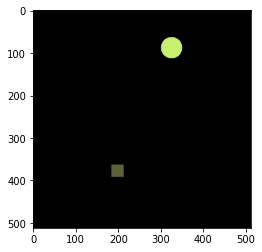

In [9]:
im = Image.open('dummy_2.png')
plt.imshow(im)

In [17]:
ds = COCODetectionDataset(img_dir='/content/',
                ann_json='/content/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=train_transform_norm)
val_ds = COCODetectionDataset(img_dir='/content/',
                ann_json='/content/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=validation_transform_norm)
train_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=2,
                                        shuffle=True,
                                        num_workers=8,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)
val_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=0,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)


label_map: {0: 0, 1: 1}
label_map: {0: 0, 1: 1}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
len(ds)

2

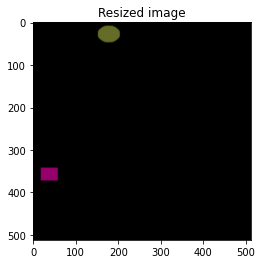

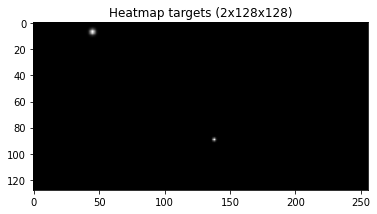

In [19]:
img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale, boxes_aug, target= ds[0]
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img_u = img.transpose(1,2,0)*std + mean# unnormalize
# img = img 
plt.imshow(img_u)
plt.title("Resized image")

plt.show()
c,h,w = hm.shape
nrows = 1
ncols = 2
hm_u = hm.reshape(nrows, ncols, h, w).swapaxes(1,2).reshape(h*nrows, w*ncols)
# hm_u = hm.transpose(1,2,0)
plt.imshow(hm_u,cmap='gray')
plt.title("Heatmap targets (2x128x128)")
plt.show()

# Background

## Single Stage vs Two Stage
<a id='single-vs-two-stage'></a>

## Centernet

# Preprocessing

## Encode Class Keypoints

```python
def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap
```

## Encoding bounding boxes

```python
centers = np.array([bboxes[:,0]+bboxes[:,2]//2,bboxes[:,1]+bboxes[:,3]//2,bboxes[:,2],bboxes[:,3]]).T
for ind,(c,l )in enumerate(zip(centers,classes)):
    h, w = c[3]/MODEL_SCALE, c[2]/MODEL_SCALE
    radius = gaussian_radius((math.ceil(h), math.ceil(w)))
    radius = max(0, int(radius))
    # print("radius:", radius)
    draw_umich_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
                            radius)
    # draw_msra_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
    #                         radius)
    reg_mask[ind] = 1
    wh[ind] = c[2:]/input_size
    draw_dense_reg(reg,hm[l],c[:2]//MODEL_SCALE,wh[ind],radius)
    inds[ind] = (int(c[1])//MODEL_SCALE)*feature_scale + (int(c[0])//MODEL_SCALE)
```

## Encode Width and Height Regression

```python
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)

  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]

  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap
```

# Model Architecture


## Backbone

```python
if model_name == 'mv3':
            basemodel = torchvision.models.mobilenet_v3_small(pretrained=True)
            num_ch = 576
elif model_name == 'resnet18':
            basemodel = torchvision.models.resnet18(pretrained=True)
            num_ch = 512
basemodel = nn.Sequential(*list(basemodel.children())[:-2])
# set basemodel
self.base_model = basemodel
# Neck
self.up1 = up(num_ch, 512,bilinear=True)
self.up2 = up(512, 256,bilinear=True)
self.up3 = up(256, 256,bilinear=True)
```

## Class Head and Regression Head

```python

# output classification
self.outc = nn.Conv2d(256, n_classes, 1)

self.outr = nn.Conv2d(256, 2, 1)
```

## Initalization of conv layers in Neck for Focal Loss

```python
'''
Author of focal loss:  all new conv layers except the 
final layer, subnets are initalized  with bias b=0 and
a Gaussian weight filled with sigma=0.01

Weight init improves training stability for both the 
cross entropy and focal loss in the case of heavy class
imbalance
'''
for m in self.conv.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias,0)
```

## Initalization of Layers in Head for Focal Loss

```python
'''
Author: the final conv later set the bias
initalization to log((1-pi)/pi)
pi specifies that at the start of training,
every anchor should be labeled as foreground
with confidence of about pi. pi is a variable that is 0.01

This initalization prevents a large number of background 
anchors from generating a large destabalizing loss value in the
in the first iteration of training
'''
self.outc.bias.data.fill_(-2.19)
# output residue
self.outr.bias.data.fill_(-2.19)
def forward(self, x):
batch_size = x.shape[0]
x = self.base_model(x) 

x = self.up1(x)
x = self.up2(x)
x = self.up3(x)
outc = self.outc(x)
outr = self.outr(x)
return outc, outr
```

In [20]:
model = centernet(ds.num_classes,model_name='mv3')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

# Loss Function

# Focal Loss
$$
L_k = \frac{-1}{N} \sum_{xyc}
\begin{cases}
(1 - \hat{Y}_{xyc})^{\alpha} 
        \log(\hat{Y}_{xyc})  & \text{ if } Y_{xyc}=1 \\
\begin{array}{c}
        (1-Y_{xyc})^{\beta} 
        (\hat{Y}_{xyc})^{\alpha}\\
        \log(1-\hat{Y}_{xyc})
        \end{array} & \text{ otherwise }
\end{cases}
$$

```python 
def focal_loss(pred, gt):
  ''' Modified focal loss.
    Arguments:
      pred (batch x h x w)
      gt (batch  x h x w)
  '''
  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0
  prob_pred = F.sigmoid(pred)
  pos_loss = F.logsigmoid(pred) * torch.pow(1 - prob_pred, 2) * pos_inds
  neg_loss = F.logsigmoid(1 - pred) * torch.pow(prob_pred, 2) * neg_inds *  neg_weights 

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss =  loss - (pos_loss + neg_loss) / (num_pos+1e-4)
  return loss
  ```

# Regression Loss
$$
L_{size} = \frac{1}{N}\sum_{k=1}^{N} \left|\hat S_{p_k} - s_k\right|.
$$

```python
def reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  mask = mask.unsqueeze(2).expand_as(gt_regr).float()

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
  ````

# Prepare and Train Training Model

In [ ]:
# LR = 1e-4
LR = 2.5e-4*2
model_mv3, losses, mask_losses, regr_losses, min_confidences, median_confidences, max_confidences = train('mv3',
                                                                                                          ds.num_classes,
                                                                                                          learn_rate=LR,
                                                                                                          epochs=150,
                                                                                                          train_loader=train_loader,
                                                                                                          val_loader=val_loader)

  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|          | 1/150 [00:08<21:01,  8.47s/it]

Epoch 0 - Min conf: 0.0007328987121582031, Median conf: 0.2503795623779297, Max conf: 1.3190257549285889
Epoch 0 - Loss: 16.407800674438477, Mask Loss: 12.480266571044922, Reg Loss: 3.9275341033935547


  1%|▏         | 2/150 [00:13<15:29,  6.28s/it]

Epoch 1 - Min conf: 0, Median conf: 0, Max conf: 0
Epoch 1 - Loss: 42.03006362915039, Mask Loss: 40.41627502441406, Reg Loss: 1.6137902736663818


  2%|▏         | 3/150 [00:17<13:41,  5.59s/it]

Epoch 2 - Min conf: 0.007661581039428711, Median conf: 0.23943305015563965, Max conf: 0.46685194969177246
Epoch 2 - Loss: 22.268512725830078, Mask Loss: 19.10971450805664, Reg Loss: 3.1587984561920166


  3%|▎         | 4/150 [00:22<12:47,  5.26s/it]

Epoch 3 - Min conf: 0, Median conf: 0, Max conf: 0
Epoch 3 - Loss: 18.050132751464844, Mask Loss: 15.927123069763184, Reg Loss: 2.12300968170166


  3%|▎         | 5/150 [00:28<13:05,  5.41s/it]

Epoch 4 - Min conf: 0, Median conf: 0, Max conf: 0
Epoch 4 - Loss: 14.300559997558594, Mask Loss: 11.40742015838623, Reg Loss: 2.893139362335205


  4%|▍         | 6/150 [00:33<12:28,  5.20s/it]

In [ ]:
len(losses)

In [ ]:
# LR = 2.5e-4*2
model_resnet18, losses_resnet18, mask_losses_resnet18, regr_losses_resnet18 = train('resnet18',
                                                                                    ds.num_classes,
                                                                                    learn_rate=1e-4,
                                                                                    epochs=50,
                                                                                    train_loader=train_loader,
                                                                                    val_loader=val_loader)


# Visualize Loss Curves

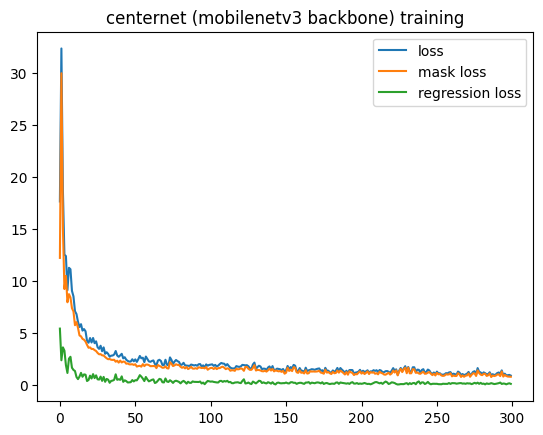

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses)),mask_losses)
plt.plot(range(len(losses)),regr_losses)
plt.title("centernet (mobilenetv3 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

## Visualize Confidence Scores over training

In [ ]:
plt.plot(range(len(min_confidences)),min_confidences )
plt.plot(range(len(median_confidences)),median_confidences)
plt.plot(range(len(max_confidences)),max_confidences)
plt.title("confidence scores for centernet (mv3 backbone) during training")
plt.legend(['min_confidences','median_confidences','max_confidences'])
plt.show()

## Visualize Training Loss for Resnet18

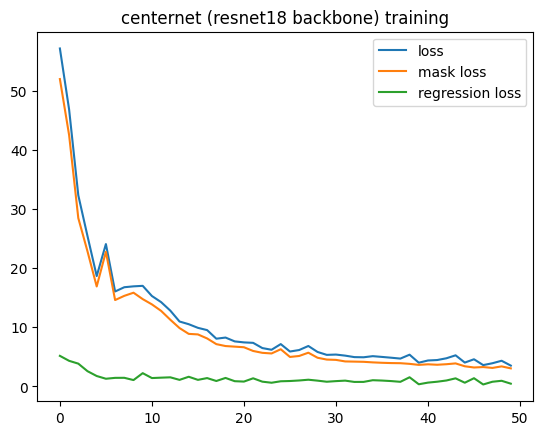

In [ ]:
plt.plot(range(len(losses_resnet18)),losses_resnet18 )
plt.plot(range(len(losses_resnet18)),mask_losses_resnet18)
plt.plot(range(len(losses_resnet18)),regr_losses_resnet18)
plt.title("centernet (resnet18 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

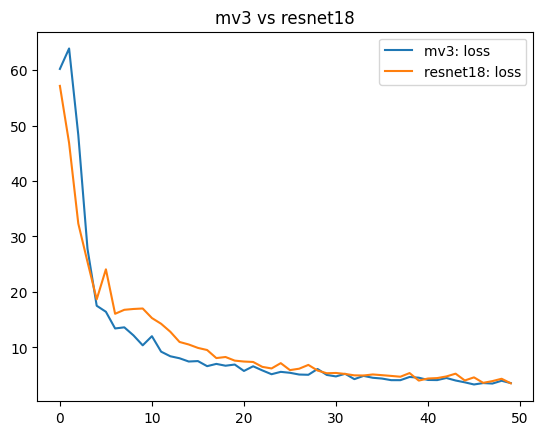

In [ ]:
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses_resnet18)),losses_resnet18)
plt.title("mv3 vs resnet18")
plt.legend(['mv3: loss','resnet18: loss'])
plt.show()

# Visualize Predictions

In [ ]:
# model_mv3(torch.rand(1,3,512,512))

In [ ]:
model_mv3.eval()
for img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale,boxes_aug, target in val_loader:
        break

pred_hm, pred_regs = model_mv3(img)# (4,1,128,128), (4,2,128,128)
pred_hm = torch.sigmoid(pred_hm)
# bboxes,scores,classes = pred2box_multiclass(pred_hm[0].cpu().data.numpy(),
#                                                         pred_regs[0].cpu().detach().numpy(),128,1,thresh=0.0)
bboxes,scores,classes = pred2box_multiclass(pred_hm[0].data.numpy(),pred_regs[0].data.numpy(),128,1,thresh=0.15)
bboxes,scores,classes =  filter_and_nms(bboxes,scores,classes,nms_threshold=0.45,n_top_scores=20)
print(bboxes)

[[ 89.  67. 113.  90.]
 [ 26.  22.  28.  25.]
 [ 27.  22.  29.  25.]
 [ 25.  22.  27.  25.]
 [ 26.  21.  28.  23.]
 [ 27.  21.  29.  23.]
 [ 28.  22.  30.  25.]
 [ 28.  21.  31.  23.]
 [ 24.  21.  27.  23.]
 [ 29.  21.  32.  25.]
 [ 26.  21.  29.  21.]
 [ 27.  23.  29.  28.]
 [ 27.  21.  30.  22.]
 [ 25.  21.  28.  21.]
 [ 25.  23.  28.  28.]
 [ 28.  23.  30.  28.]
 [ 23.  22.  26.  25.]
 [ 22.  21.  26.  23.]
 [ 23.  21.  27.  21.]
 [ 28.  20.  32.  22.]]


In [ ]:
hm.shape

torch.Size([1, 2, 128, 128])

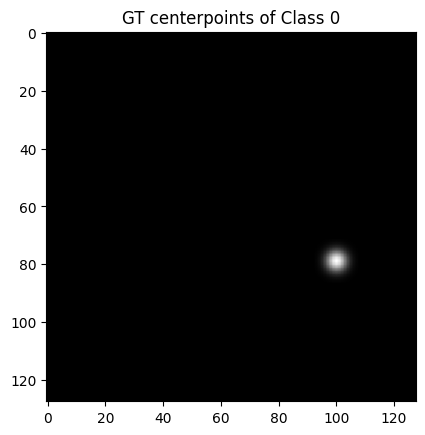

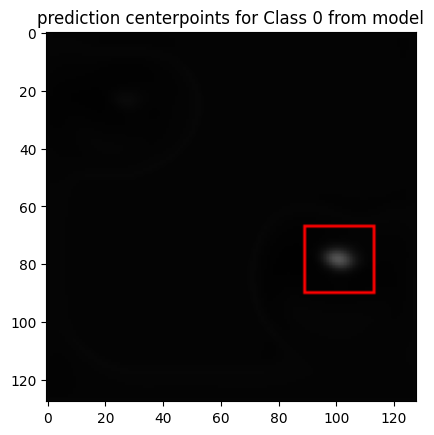

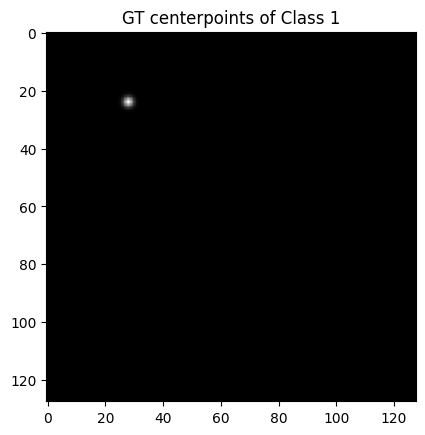

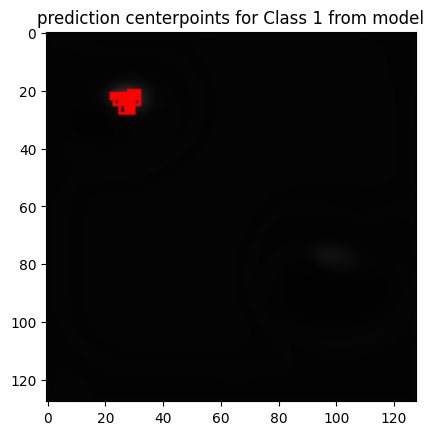

In [ ]:
for i in range(hm.shape[1]):
    hm_gt = hm[0].data.numpy()[i]
    hm_pred = pred_hm[0].data.numpy()[i]
    hm_pred = np.dstack([hm_pred*255]*3).astype(np.uint8)
    for b,c in zip(bboxes,classes):
        if c == i:
            x,y,x2,y2 = [int(k) for k in b]
            # print(x,y)
            cv2.rectangle(hm_pred,(x,y),(x2,y2),(255,0,0),1)
        
    plt.imshow(hm_gt,cmap='gray')
    plt.title("GT centerpoints of Class {}".format(i))
    plt.show()
    plt.imshow(hm_pred)
    plt.title("prediction centerpoints for Class {} from model".format(i))
    plt.show()
